In [1]:
# 书第80页
import numpy as np
import matplotlib.pyplot as plt
from utils.GridWorld import GridWorld
from utils.AgentBasics import Agent, Policy

# Grid world
注：从这一节开始，只有术语，符号和代码注释使用英文，其余部分使用中文<p>
Grid world里包含许多格子，每一个格子都对应一个数值，表示这个格子是否为终点格，当agent到达终点格的时候，获得reward=1，不到达终点格不获得reward<p>
终点格为grid[0, 0]和grid[-1, -1]，即左下角和右上角<p>
agent在任意格子中可以采取4种不同action，上，下，左，右<p>
当agent已经处于世界边缘，往世界外走的话，会出现在世界的另一端 (wrap)

In [2]:
world_size = 5

展示Grid world

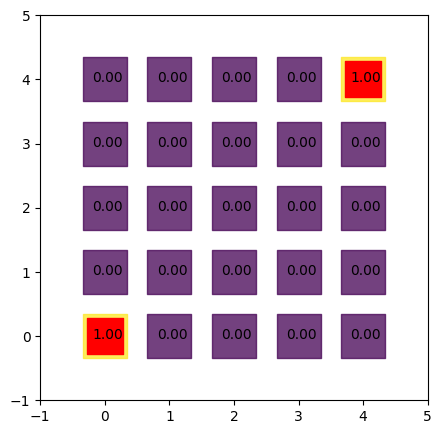

In [3]:
# Show grid world with two terminal states
grid_world = GridWorld(world_size, terminal_states=[(0, 0), (world_size-1, world_size-1)])
grid_world.render()
plt.show()

# Iterative Policy Evaluation

对于一个policy $\pi(a|s)$ ，可以使用 policy evaluation 去计算当前policy下每个state的state-value<p>
已知关于当前policy $\pi$ 的 state-value function 就是 Bellman equation:
$$v_\pi(s)=\sum_a \pi(a|s) \cdot \sum_{s'} \sum_r p(s',r|s,a) \cdot (r-\gamma \cdot v_\pi(s'))$$
但一次更新并不能直接求出每个state的state-value，因为state之间存在相互的依赖(因果)关系，因此state-value之间也存在依赖关系。假设state s1依赖s2，s2又依赖s3，那么$v_\pi(s1)$的计算就依赖$v_\pi(s2)$，$v_\pi(s2)$的计算又依赖$v_\pi(s3)$。根据上述公式，使用三个state的旧state-value算出并更新得到三个state的新state-value，而此时，由于s1的新state-value是根据s2的旧state-value算出的，但s2有了新的state-value，导致s1的state-value还得再次更新。于是最终还是需要多次地更新所有state的state-value，直到收敛。<p>
注意在此过程中 $\pi(a|s)$ 是不变的，这个过程收敛之后，每个state的state-value就代表了在当前policy指导下每个state最终的价值。

NOTE: getModelNextStateProbs(state, action) assumes a model exists for the environment.


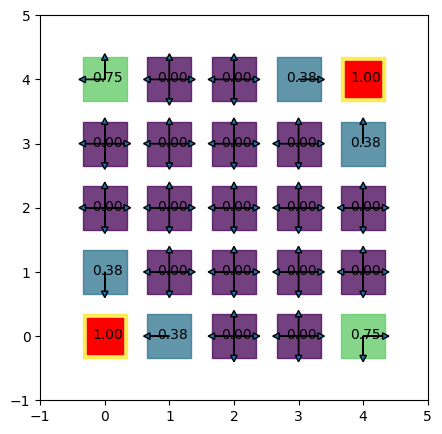

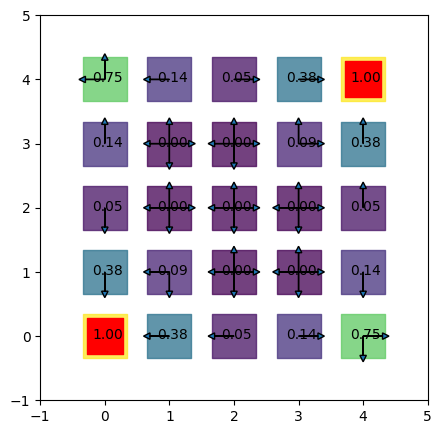

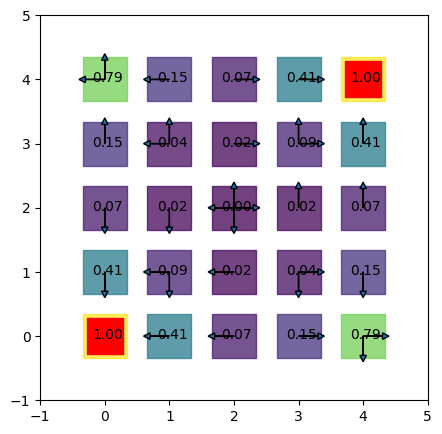

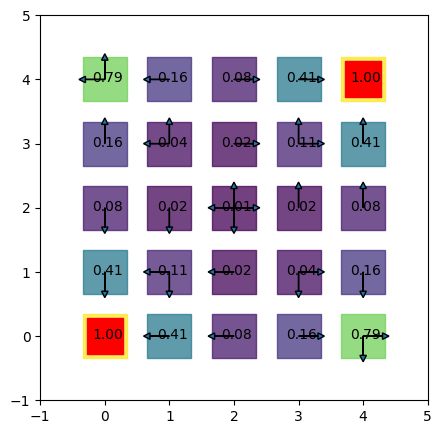

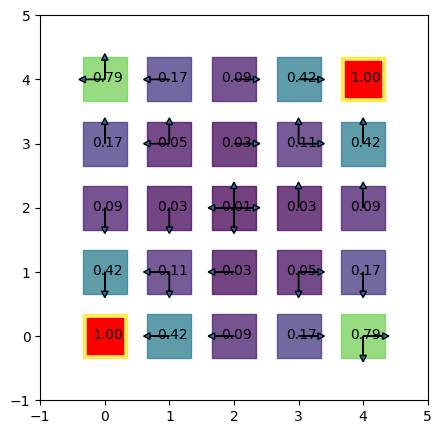

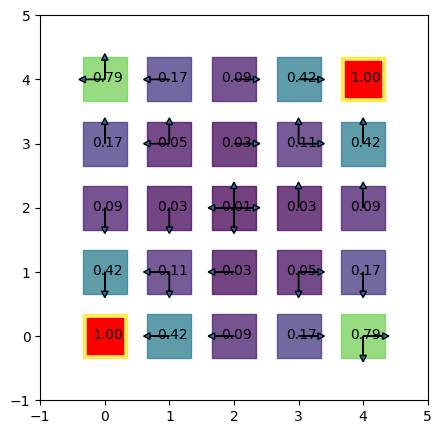

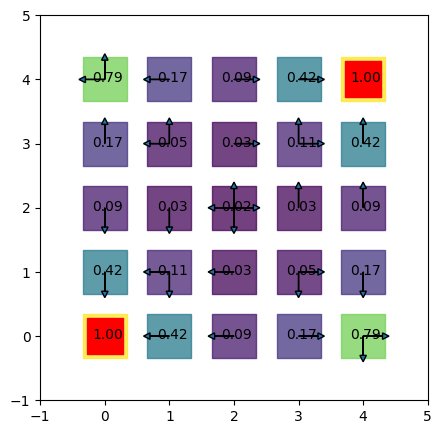

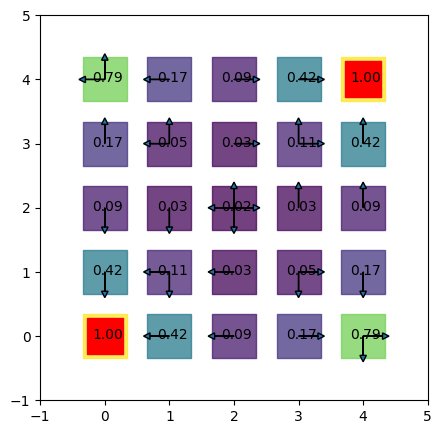

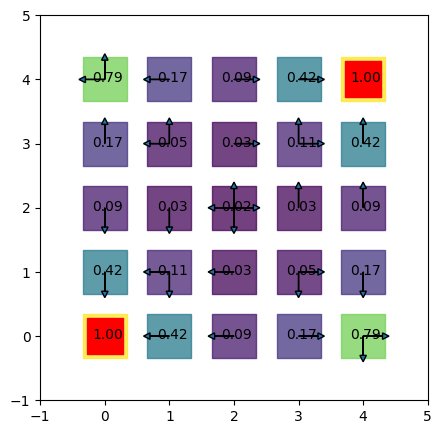

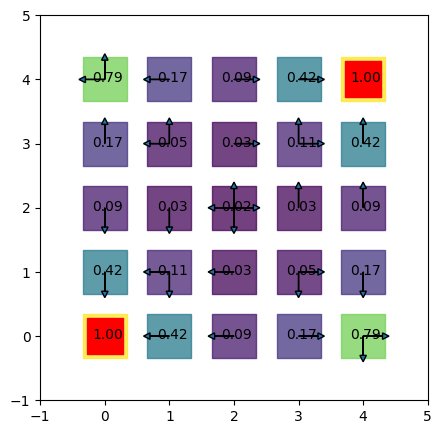

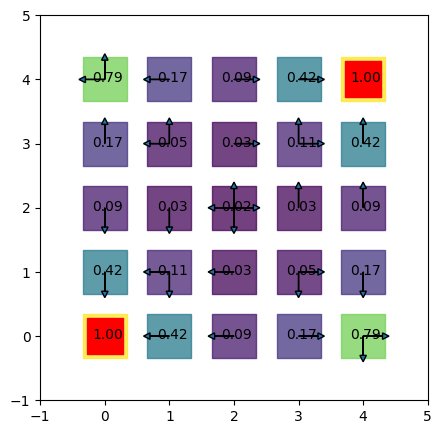

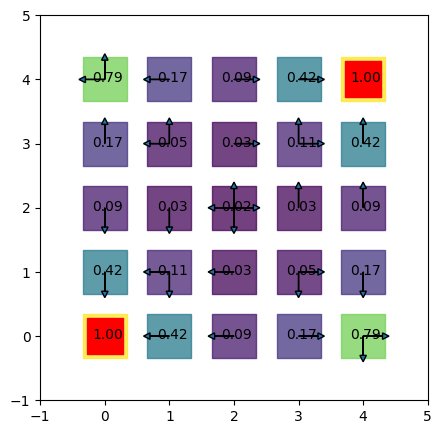

In [4]:
# This is our toy policy, all actions happend at same chance
agent = Agent(grid_world, Policy(grid_world))
# set terminal state values to reward
agent.initTerminalValues(grid_world)

# policy iteration
threshold = 0.001  # if the total update of the state-value function is less than this threshold, then stop iteration
update_amount = 100     # the total update of the state-value fcuntion
gamma = 0.5     # return discount

while update_amount >= threshold:
    new_agent = agent.copy(grid_world)
    update_amount = 0
    # iterate over all states
    for sid in grid_world.getNonTerminalStateIds():
        
        # compute bellman equation to update value function for state (y, x)
        # p(s', r | s, a) * (r + gamma*v')
        # p(s', r | s, a) = 1, because taking action a at state s, can only go to one fixed s' and get fixed r
        new_agent.state_value[sid] = 0
        valid_action_ids = grid_world.getValidActionIds(sid)    # 4 actions
        for aid in valid_action_ids:
            next_state_id = np.where(grid_world.getModelNextStateProbs(sid, aid) == 1)[0][0]     # there is only one possible next state for each action
            new_agent.action_value[sid, aid] = grid_world.getReward(next_state_id) + gamma * agent.state_value[next_state_id]
            new_agent.state_value[sid] += agent.policy[sid, aid] * new_agent.action_value[sid, aid]

        update_amount += np.abs(agent.state_value[sid] - new_agent.state_value[sid])

    agent = new_agent
    
    grid_world.render(agent)
    plt.show()

从上面的过程中可以明显看出，越接近terminal state的state，其state-value越大，因为离终点越近的state就是越好的state。左上角和右下角的state可以利用wrap move直接走到terminal state因此state-value最高。同时也可以从前几次更新看出，由于state间的依赖关系，最接近terminal state的state会更早地接触到从terminal state传过来的reward。

# Policy Improvement

在 policy evaluation 之后, 我们已经有了根据$\pi(a|s)$对于每个state的state-value估计<p>
但是这个policy可能很垃圾，比如他会平均且随机地选每个action，现在要让它更聪明<p>
需要注意的是state-value，或者action-value在此时并不一定符合policy，比如，policy可能是平均地选择每一个action，但就算如此也会有更好的action和更坏的action<p>
对于state s，经过根据 $\pi(a|s)$ 的policy evaluation之后，会存在一个当前能采取的最好的action，即拥有最高的 action-value $q_\pi(s, a)$ 的action, 那么就很简单直接让policy在这个state的情况下无脑选这个action，那么这个policy就会更聪明，更准确地说，他会更不笨（可能和以前一样聪明），policy更新方式如下 $$\pi'(s)=\underset{a}{argmax} \sum_{s'} \sum_r p(s',r|s,a) \cdot (r-\gamma \cdot v_\pi(s'))$$
按照此公式更新policy，即对于每个state，就让policy无脑选当前state下最好的action，这叫policy improvement<p>
"In policy evaluation, we make state-value function greedy to the policy, now in policy improvement, we make policy greedy to the state-value function"<p>

# Policy Iteration
第一步. policy evaluation<p>
第二步. policy improvement<p>
注意第二步之后policy变了，而第一步又取决于policy，所以你得重新回到第一步，重新根据新的policy更新所有state的state-value，直到收敛。<p>
合起来叫policy iteration<p>

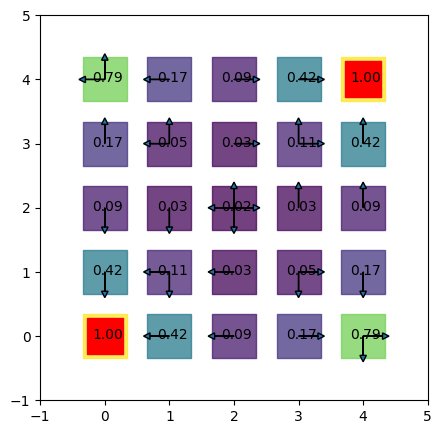

In [5]:
# This is our toy policy, all actions for all states are initialized to the same chance
# We have a policy for each state
agent = Agent(grid_world, Policy(grid_world))
# set terminal state values to reward
agent.initTerminalValues(grid_world)

threshold = 0.001
update_amount = 100
gamma = 0.5
while True:
    # STEP 1. Policy Evaluation
    while update_amount >= threshold:
        new_agent = agent.copy(grid_world)
        update_amount = 0
        # iterate over all non terminal states
        for sid in grid_world.getNonTerminalStateIds():
            
            # compute bellman equation to update value function for state (y, x)
            # p(s', r | s, a) * (r + gamma*v')
            # p(s', r | s, a) = 1, because taking action a at state s, can only go to one fixed s' and get fixed r
            new_agent.state_value[sid] = 0
            valid_action_ids = grid_world.getValidActionIds(sid)    # 4 actions
            for aid in valid_action_ids:
                next_state_id = np.where(grid_world.getModelNextStateProbs(sid, aid) == 1)[0][0]     # there is only one possible next state for each action
                new_agent.action_value[sid, aid] = grid_world.getReward(next_state_id) + gamma * agent.state_value[next_state_id]
                new_agent.state_value[sid] += agent.policy[sid, aid] * new_agent.action_value[sid, aid]

            update_amount += np.abs(agent.state_value[sid] - new_agent.state_value[sid])

        agent = new_agent
    
    # STEP 2. Policy Improvement
    # iterate over all states
    policy_changed = False
    new_policy = agent.policy.copy(grid_world)
    for sid in grid_world.getNonTerminalStateIds():

        # get the best action for this state according to the current action_value function
        valid_action_ids = grid_world.getValidActionIds(sid)
        best_action_ids = agent.getBestActions(sid)
        
        for aid in valid_action_ids:
            new_policy[sid, aid] = int(aid in best_action_ids)

        new_policy.normalize()
        
        policy_changed = agent.policy.diff(new_policy) > 0.01
        agent.policy = new_policy
    
    if not policy_changed:
        break


grid_world.render(agent)
plt.show()

你可以看到最后这个，巨鸡儿好看的图，箭头表示在那个state可以采取的最好的action，state上的数字表示state-value，多个箭头的话就是指可以有多种走法。

# 缺点
每一次更新policy，都需要进行policy evaluation，本来这个更新就是一个多次循环的过程，使用policy evaluation就是循环里面套循环，每次policy evaluation又要循环直到收敛，而且还要多次地循环所有state，太麻烦了。